# Tom and Jerry Image Classification
https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification

## Import libraries

In [2]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import os

## Function to extract features of an image

### Tensorflow ResNet function to extract features

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input


image_size = (224, 224)
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
# Function to extract features from an image using a pre-trained CNN model
def extract_resnet_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    image = resnet_preprocess_input(image)
    features = resnet_model.predict(np.expand_dims(image, axis=0))
    flattened_features = features.flatten()  
    return flattened_features


### General function

In [4]:
def extract_features(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert the image to grayscale (unsigned integer type)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the average RGB values
    average_rgb = np.mean(image_rgb, axis=(0, 1))
    
    # Extract 
    features = extract_resnet_features(image_path)
    # Calculate the pixel percentage matching the color of Tom and Jerry
    # Calculate the percentage of pixels in the image that match the color of Tom or Jerry
    tom_color_1 = np.array([191, 185, 183])  # Tom's characteristic color 1
    tom_color_2 = np.array([142, 54, 69])    # Tom's characteristic color 2
    tom_color_3 = np.array([236, 232, 44])   # Tom's characteristic color 3
    tom_color_4 = np.array([190, 0, 1])      # Tom's characteristic color 4
    jerry_color_1 = np.array([193, 131, 97])  # Jerry's characteristic color 1
    jerry_color_2 = np.array([173, 77, 65])   # Jerry's characteristic color 2
    jerry_color_3 = np.array([243, 227, 239]) # Jerry's characteristic color 3
    
    # Calculate the mask for pixels matching the color of Tom or Jerry
    tom_mask = np.any(np.isclose(image_rgb, tom_color_1, atol=20), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_2, atol=5), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_3, atol=5), axis=-1) \
               | np.any(np.isclose(image_rgb, tom_color_4, atol=10), axis=-1)
    jerry_mask = np.any(np.isclose(image_rgb, jerry_color_1, atol=20), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_2, atol=4), axis=-1) \
                 | np.any(np.isclose(image_rgb, jerry_color_3, atol=4), axis=-1)
    
    tom_pixel_percentage = np.mean(tom_mask)
    jerry_pixel_percentage = np.mean(jerry_mask) 
    
    # Return the extracted features
    return {
        'Image_Path': image_path,
        'Average_Red': average_rgb[0],  # Red component
        'Average_Green': average_rgb[1],  # Green component
        'Average_Blue': average_rgb[2],  # Blue component
        'Tom_Pixel_Percentage': tom_pixel_percentage,
        'Jerry_Pixel_Percentage': jerry_pixel_percentage,
        **{'ResNet_Feature_'+str(i): f for i, f in enumerate(features)},
    }


## Initialize

In [4]:
# Update data_dir and image_size
data_dir = './kaggle/input/tom_and_jerry/tom_and_jerry'

data = []
data_ = []
labels = []
labels_ = []

subfolders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']

label_categories = {
    0: "Jerry",
    1: "Tom",
    2: "None",
    3: "Both"
}

## Create Dataframes

In [18]:
do_testing = False

### Testing

In [ ]:
# TRAIN
# Set the maximum number of iterations per subfolder
if do_testing: 
    max_iterations_per_subfolder = 15

    data_train_dir = os.path.join(data_dir, 'train')
    counter = 0  # Initialize counter

    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_train_dir, subfolder)
        image_files = os.listdir(folder_path)
        
        # Reset the counter for each subfolder
        counter_per_subfolder = 0  
        
        for image_file in image_files:
            # Check if the maximum number of iterations per subfolder has been reached
            if counter_per_subfolder >= max_iterations_per_subfolder:
                break  # Exit the loop for the current subfolder
            
            image_path = os.path.join(folder_path, image_file)
            try:
                image_info = extract_features(image_path)
                # Add image info and label to lists
                data.append(image_info)
                labels.append(label)
                counter += 1  # Increment the total counter
                counter_per_subfolder += 1  # Increment the counter for the current subfolder
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    # Create a DataFrame
    df_train = pd.DataFrame(data)
    # Add 'Label' column
    df_train['Label'] = labels

    # TEST 
    # Set the maximum number of iterations per subfolder
    max_iterations_per_subfolder = 5

    data_test_dir = os.path.join(data_dir, 'test')
    counter = 0  # Initialize counter

    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_test_dir, subfolder)
        image_files = os.listdir(folder_path)
        
        # Reset the counter for each subfolder
        counter_per_subfolder = 0  
        
        for image_file in image_files:
            # Check if the maximum number of iterations per subfolder has been reached
            if counter_per_subfolder >= max_iterations_per_subfolder:
                break  # Exit the loop for the current subfolder

            image_path = os.path.join(folder_path, image_file)
            try:
                image_info = extract_features(image_path)
                # Add image info and label to lists
                data_.append(image_info)
                labels_.append(label)
                counter += 1  # Increment the total counter
                counter_per_subfolder += 1  # Increment the counter for the current subfolder
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    # Create a DataFrame
    df_test = pd.DataFrame(data_)
    # Add 'Label' column
    df_test['Label'] = labels_
    df_test


### Read dataset

In [ ]:
if not do_testing:
    data_train_dir = os.path.join(data_dir, 'train')
    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_train_dir, subfolder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            try:
                image_info = extract_features(image_path)
                # Add image info and label to lists
                data.append(image_info)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    # Create a DataFrame
    df_train = pd.DataFrame(data)
    # Add 'Label' column
    df_train['Label'] = labels
    df_train

In [ ]:
if not do_testing:
    data_test_dir = os.path.join(data_dir, 'test')
    for label, subfolder in enumerate(subfolders):
        folder_path = os.path.join(data_test_dir, subfolder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            try:
                image_info = extract_features(image_path)
                # Add image info and label to lists
                data_.append(image_info)
                labels_.append(label)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")
    # Create a DataFrame
    df_test = pd.DataFrame(data_)
    # Add 'Label' column
    df_test['Label'] = labels_
    df_test

## Save Dataframes into csv

In [ ]:
df_train.to_csv('./data/train_data.csv', index=False)
df_test.to_csv('./data/test_data.csv', index=False)

## Remove columns with high and low variance

In [7]:

selector = VarianceThreshold(threshold=0.1)

# Separate features and labels from training and testing dataframes
X_train = df_train.drop(columns=['Image_Path', 'Label'])
y_train = df_train['Label']
X_test = df_test.drop(columns=['Image_Path', 'Label'])
y_test = df_test['Label']

# Fit the selector to the training data
selector.fit(X_train)

# Get mask of features to keep
mask = selector.get_support()

# Filter the original dataframes based on the mask
selected_features_train = X_train.columns[mask]
selected_features_test = X_test.columns[mask]

df_train_filtered = df_train[['Image_Path', *selected_features_train, 'Label']]
df_test_filtered = df_test[['Image_Path', *selected_features_test, 'Label']]

# Display or return the filtered dataframes
df_train_filtered


,Image_Path,Average_Red,Average_Green,Average_Blue,ResNet_Feature_0,ResNet_Feature_1,ResNet_Feature_3,ResNet_Feature_4,ResNet_Feature_5,ResNet_Feature_6,...,ResNet_Feature_2035,ResNet_Feature_2037,ResNet_Feature_2038,ResNet_Feature_2042,ResNet_Feature_2043,ResNet_Feature_2044,ResNet_Feature_2045,ResNet_Feature_2046,ResNet_Feature_2047,Label
0,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,112.418660,108.282672,87.389278,0.528285,0.029902,1.315238,0.634177,0.193334,0.283515,...,0.238022,0.855130,0.054288,0.005966,0.028109,0.123447,1.839331,0.870836,0.000000,0
1,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,57.509216,49.321968,47.493701,1.309414,1.736403,0.170851,0.000000,2.932875,0.530004,...,0.566767,0.067213,0.082491,0.074207,0.539539,0.147099,0.291170,0.246790,0.003313,0
2,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,96.605145,92.911129,85.275176,0.559744,0.069923,1.542000,0.559682,0.485890,0.168751,...,0.738310,0.549561,0.338623,0.000000,0.034666,0.000000,3.304345,0.307587,0.581977,0
3,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,84.832106,81.504769,82.176915,0.150879,0.339460,0.028849,1.609796,0.126857,0.307259,...,0.000000,1.804228,1.851759,0.153898,0.478254,0.911931,1.486619,1.318023,0.614202,0
4,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,72.107272,64.458826,47.950459,0.592783,0.034610,0.032991,0.019603,0.026858,2.837760,...,0.653814,1.729966,0.078469,0.009067,0.060701,0.745618,0.513924,0.269124,2.430139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,86.809985,73.588483,70.433480,0.027479,0.565555,0.454398,0.109362,0.334267,0.217785,...,0.081116,1.740194,0.147026,0.104712,0.004578,0.253000,1.185171,0.618679,0.028477,3
4438,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,102.087517,88.566867,85.885807,0.569003,0.801708,2.996027,0.000000,1.016686,0.308584,...,0.064533,1.298695,1.040156,0.107155,0.278814,0.192668,3.525775,0.019981,0.326274,3
4439,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,60.445131,61.805913,59.170038,1.818681,0.569909,1.983910,0.036266,0.658086,0.299647,...,0.427472,1.030174,1.582558,0.133654,0.436760,0.298897,0.877941,0.526452,1.503341,3
4440,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,90.063471,57.759946,58.699454,1.452093,0.485698,1.711687,0.077760,0.254750,0.015883,...,0.013486,2.981479,1.193068,0.151251,0.190500,0.230602,0.352457,0.597941,0.900871,3


## Scaling

In [8]:
# Separate features and labels
X_train = df_train_filtered.drop(columns=['Image_Path', 'Label'])
y_train = df_train_filtered['Label']
X_test = df_test_filtered.drop(columns=['Image_Path', 'Label'])
y_test = df_test_filtered['Label']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test features using the same scaler
X_test_scaled = scaler.transform(X_test)

# Create new DataFrames with the scaled features
df_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_train_scaled['Image_Path'] = df_train_filtered['Image_Path']
df_train_scaled['Label'] = y_train

df_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
df_test_scaled['Image_Path'] = df_test_filtered['Image_Path']
df_test_scaled['Label'] = y_test

df_train_scaled

,Average_Red,Average_Green,Average_Blue,ResNet_Feature_0,ResNet_Feature_1,ResNet_Feature_3,ResNet_Feature_4,ResNet_Feature_5,ResNet_Feature_6,ResNet_Feature_8,...,ResNet_Feature_2037,ResNet_Feature_2038,ResNet_Feature_2042,ResNet_Feature_2043,ResNet_Feature_2044,ResNet_Feature_2045,ResNet_Feature_2046,ResNet_Feature_2047,Image_Path,Label
0,0.848213,0.681923,0.327124,-0.659603,-1.055975,0.069466,0.727703,-0.707818,-0.208360,-0.395763,...,-0.485969,-0.851324,-0.713420,-0.830392,-0.654132,0.061983,0.202505,-0.878941,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,0
1,-1.109578,-1.659803,-1.106252,0.480751,1.396950,-1.125619,-0.873168,3.887186,0.320502,-0.678415,...,-1.459662,-0.818310,-0.516428,0.500140,-0.607831,-1.117210,-0.721775,-0.870777,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,0
2,0.284384,0.071416,0.251168,-0.613677,-0.998449,0.306273,0.539652,-0.217116,-0.454596,-0.190816,...,-0.863586,-0.518479,-0.730641,-0.813334,-0.895791,1.177846,-0.631729,0.555288,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,0
3,-0.135383,-0.381608,0.139853,-1.210569,-0.611016,-1.273911,3.190484,-0.819320,-0.157415,-0.395344,...,0.686910,1.252812,-0.286386,0.340702,0.889402,-0.206668,0.864838,0.634703,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,0
4,-0.589086,-1.058617,-1.089842,-0.565444,-1.049207,-1.269586,-0.823683,-0.987047,5.271980,-0.847768,...,0.595139,-0.823017,-0.704468,-0.745602,0.563827,-0.947544,-0.688697,5.109914,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,-0.064862,-0.696017,-0.282067,-1.390717,-0.286028,-0.829510,-0.597103,-0.471432,-0.349388,-0.453290,...,0.607778,-0.742764,-0.428369,-0.891611,-0.400520,-0.436273,-0.170968,-0.808760,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,3
4438,0.479857,-0.101124,0.273107,-0.600159,0.053419,1.824714,-0.873168,0.673182,-0.154571,0.575913,...,0.062181,0.302742,-0.421318,-0.178159,-0.518624,1.346503,-1.057704,-0.074869,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,3
4439,-1.004898,-1.163982,-0.686743,1.224218,-0.279770,0.767760,-0.781620,0.071707,-0.173747,0.196583,...,-0.269653,0.937683,-0.344822,0.232750,-0.310672,-0.670282,-0.307566,2.825905,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,3
4440,0.051141,-1.324674,-0.703650,0.689045,-0.400815,0.483477,-0.676877,-0.604806,-0.782585,0.840684,...,2.141737,0.481742,-0.294026,-0.407916,-0.444365,-1.070529,-0.201682,1.341173,./kaggle/input/tom_and_jerry/tom_and_jerry/tra...,3


## EDA

In [9]:
df_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442 entries, 0 to 4441
Columns: 1625 entries, Average_Red to Label
dtypes: float64(1623), int64(1), object(1)
memory usage: 55.1+ MB


In [10]:
df_train_scaled.describe()

,Average_Red,Average_Green,Average_Blue,ResNet_Feature_0,ResNet_Feature_1,ResNet_Feature_3,ResNet_Feature_4,ResNet_Feature_5,ResNet_Feature_6,ResNet_Feature_8,...,ResNet_Feature_2035,ResNet_Feature_2037,ResNet_Feature_2038,ResNet_Feature_2042,ResNet_Feature_2043,ResNet_Feature_2044,ResNet_Feature_2045,ResNet_Feature_2046,ResNet_Feature_2047,Label
count,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,...,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4.442000e+03,4442.000000
mean,9.277685e-17,-5.758563e-17,3.327170e-16,-1.343665e-16,3.199202e-17,4.478883e-17,2.559361e-17,-1.759561e-16,-1.023745e-16,3.839042e-17,...,-8.317925e-17,-2.495377e-16,5.118723e-17,-2.879282e-17,-1.307674e-16,-6.398404e-18,-3.199202e-18,3.519122e-17,4.478883e-17,1.339487
std,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,...,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,0.982629
min,-3.160064e+00,-3.618710e+00,-2.812616e+00,-1.430834e+00,-1.098956e+00,-1.304039e+00,-8.731679e-01,-1.032095e+00,-8.166636e-01,-1.085518e+00,...,-6.586243e-01,-1.498629e+00,-9.148739e-01,-7.306406e-01,-9.035198e-01,-8.957910e-01,-1.338986e+00,-1.087299e+00,-8.789406e-01,0.000000
25%,-6.722023e-01,-7.003434e-01,-6.910825e-01,-7.552315e-01,-7.811819e-01,-7.350863e-01,-6.940056e-01,-7.683707e-01,-6.644761e-01,-7.441747e-01,...,-6.200889e-01,-7.113667e-01,-7.122688e-01,-6.458116e-01,-7.335242e-01,-6.563946e-01,-7.954865e-01,-7.262885e-01,-7.013023e-01,1.000000
50%,5.903606e-02,-1.180393e-02,4.654658e-02,-2.177038e-01,-2.707356e-01,-2.019221e-01,-3.323213e-01,-2.881285e-01,-3.252937e-01,-2.743256e-01,...,-3.796353e-01,-2.247654e-01,-3.354450e-01,-3.662074e-01,-3.119341e-01,-2.892899e-01,-2.297756e-01,-2.812915e-01,-3.192609e-01,1.000000
75%,6.483564e-01,7.099374e-01,7.047485e-01,5.132925e-01,5.010007e-01,4.728043e-01,3.170165e-01,4.841471e-01,2.704883e-01,4.326473e-01,...,2.143923e-01,4.376777e-01,3.627064e-01,2.736847e-01,3.825548e-01,3.492450e-01,5.777017e-01,3.984208e-01,3.724615e-01,2.000000
max,4.146270e+00,3.738403e+00,3.532498e+00,4.532798e+00,5.198140e+00,7.419892e+00,6.841592e+00,7.205941e+00,8.683028e+00,5.451306e+00,...,1.128758e+01,5.156668e+00,7.222169e+00,1.540062e+01,1.015676e+01,1.101993e+01,5.502604e+00,6.735501e+00,9.118559e+00,3.000000


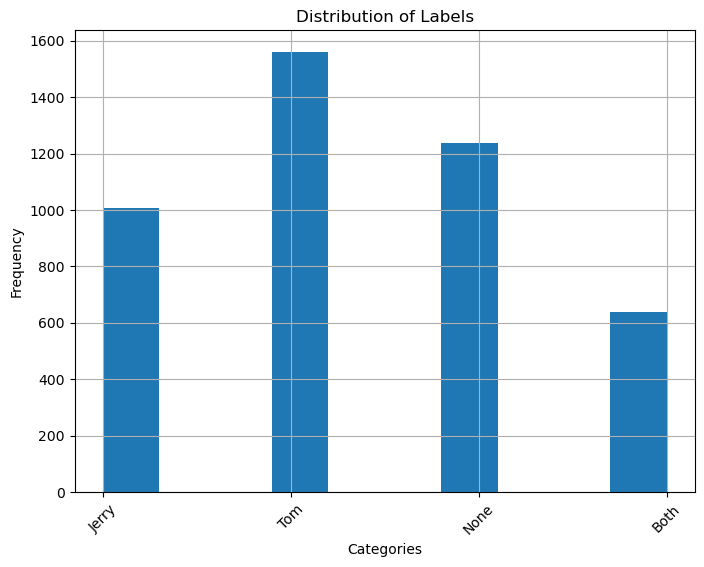

In [25]:
# Histogram of label column
plt.figure(figsize=(8, 6))
df_train_scaled['Label'].map(label_categories).hist()
plt.title('Distribution of Labels')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## PCA

In [11]:
# Separate features and labels
X_train = df_train_filtered.drop(columns=['Image_Path', 'Label'])
y_train = df_train_filtered['Label']
X_test = df_test_filtered.drop(columns=['Image_Path', 'Label'])
y_test = df_test_filtered['Label']


# Perform PCA
pca = PCA(n_components=0.98)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create new DataFrames with PCA components
df_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
df_train_pca['Label'] = y_train

df_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
df_test_pca['Label'] = y_test

df_train_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC902,PC903,PC904,PC905,PC906,PC907,PC908,PC909,PC910,Label
0,4.397675,-4.795098,5.373249,-2.135154,7.119327,2.440652,-3.581138,4.079383,3.707602,2.234122,...,-0.409734,0.047945,0.297024,-0.437412,-0.080148,-0.322287,-0.030384,0.715498,-0.258683,0
1,-5.140221,-0.464478,-5.024959,9.539178,-1.775166,3.502482,-0.510907,14.346949,3.996232,-3.818519,...,0.320918,-0.066611,-0.040643,-0.250331,-0.233244,0.231713,-0.124945,-0.349180,0.125595,0
2,-2.871541,5.597351,11.488544,7.452871,-6.898003,-3.481725,-10.846242,2.058152,-1.047376,-4.726564,...,-0.226873,-0.179853,-0.063761,-0.359223,-0.267931,0.154635,0.181822,-0.247028,0.131609,0
3,17.020795,10.239279,-3.020818,-11.455997,-11.367851,0.428874,-4.587209,8.291891,-15.892612,1.519730,...,-0.222713,-0.183024,-0.271510,-0.299876,-0.220458,0.080214,0.001298,-0.086031,0.220149,0
4,6.341826,-1.761672,16.105620,4.526057,11.993046,6.821219,-1.874611,0.899023,1.813889,-5.969777,...,0.140855,-0.191985,-0.028284,-0.049937,-0.138432,0.051414,-0.204194,-0.220258,0.126764,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,-8.612847,2.074275,-2.144486,6.733838,-3.124309,5.923397,-2.323402,1.607126,-1.390174,1.046500,...,-0.098006,0.478073,0.479072,0.142164,0.628079,0.057303,-0.271578,0.044412,0.019006,3
4438,-14.392629,4.360476,-6.960752,0.053297,-1.798992,5.242563,-2.890633,-2.823239,-2.290793,2.371969,...,0.550181,-0.172729,-0.059896,-0.426643,0.325227,-0.085336,-0.092925,-0.090265,-0.427306,3
4439,0.842402,-3.675358,-10.761197,-4.450120,1.342692,2.580862,-2.998616,-3.296310,-2.195648,-8.946582,...,0.395500,-0.290936,0.448635,-0.228667,0.019310,-0.312746,-0.204022,0.059866,0.065772,3
4440,-13.864613,1.804252,-5.331252,-0.211287,0.800797,7.135127,-1.762064,-8.790791,-4.410820,-1.813151,...,0.280404,0.410348,-0.007257,-0.124706,0.097344,0.229737,0.209323,-0.586062,-0.261179,3


## Decision Tree Classifier

In [12]:


X_train = df_train_pca.drop(columns=['Label'])
y_train  = df_train_pca['Label']


# Define the hyperparameters grid
param_grid = {'max_features': [None, 'sqrt', 'log2'],
              'ccp_alpha': [.001, .0001, 0.00001],
              'max_depth' : [6, 9, 11, 14, 16],
              'min_samples_split': [2, 3, 5, 6],
              'min_samples_leaf': [1, 2, 3, 4],
              'criterion' :['gini', 'entropy']
             }

In [ ]:
# Initialize the Decision Tree classifier
tree_clas = DecisionTreeClassifier()

# Initialize GridSearchCV
clf_GS = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
clf_GS.fit(X_train, y_train)

best_params = clf_GS.best_params_
print("Best Hyperparameters:", best_params)

In [14]:
best_dt_classifier = DecisionTreeClassifier(**best_params)
best_dt_classifier.fit(X_train, y_train)

# # Plot the decision tree with the best hyperparameters
# plt.figure(figsize=(40, 30))  # Adjust the figure size as needed
# plot_tree(best_dt_classifier, 
#           feature_names=X_train.columns, 
#           class_names=['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1'], 
#           filled=True,
#           fontsize=14)  # Adjust the fontsize parameter as needed
# plt.show()

DecisionTreeClassifier(ccp_alpha=1e-05, criterion='entropy', max_depth=14,
                       min_samples_split=6)

In [15]:
print("Hyperparameters:", best_params)
X_test = df_train_pca.drop(columns=['Label'])
y_test = df_train_pca['Label']

# Predict the labels for test data
y_pred = best_dt_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Hyperparameters: {'max_features': None, 'ccp_alpha': 1e-05, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Accuracy: 0.980414227825304

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1007
           1       0.99      0.99      0.99      1559
           2       0.98      0.98      0.98      1237
           3       0.97      0.95      0.96       639

    accuracy                           0.98      4442
   macro avg       0.98      0.98      0.98      4442
weighted avg       0.98      0.98      0.98      4442


Confusion Matrix:
[[ 982    2   15    8]
 [   4 1546    2    7]
 [   9    9 1218    1]
 [   8   11   11  609]]


### Save in a csv the best Decision Tree Hyperparameters

In [136]:
best_params_df = pd.DataFrame.from_dict([best_params])
best_params_df.to_csv('./hyperparams/best_dt_params.csv', index=False)

## .
